In [114]:
from core.metrics import *
from core.semcor_bert_pipeline import load_data
from core.analysis import annotate_mtx, access_db, get_senses
import matplotlib.pyplot as plt

In [99]:
shared_words = ['table', 'foot', 'degree', 'plane', 'model', 'right']

In [165]:
def cosine_sim_mtx(word, pos, sel_senses = []):
    data = semcor_bert_pipeline.load_data(word, pos, 'semcor')
    embeddings_by_sense = {}
    word_embeddings = data['embeddings']
    word_embeddings = np.array([np.array(e) for e in word_embeddings])
    if not len(sel_senses):
        strip_synset = lambda s: s.strip("Synset()").strip("'")
        sel_senses = [strip_synset(i) for i in data['sense_names']]
    for s in sel_senses:
        embeddings_by_sense[s] = word_embeddings[np.argwhere(np.array(data['sense_labels']) == s).flatten()]
    result_mtx = []
    for i in sel_senses:
        row = []
        for j in sel_senses:
            dist = cs_centroids(embeddings_by_sense[i], embeddings_by_sense[j])
            row.append(dist)
        result_mtx.append(np.asarray(row))
    result_mtx = np.asarray(result_mtx)
    return result_mtx, sel_senses


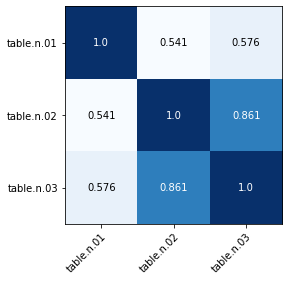

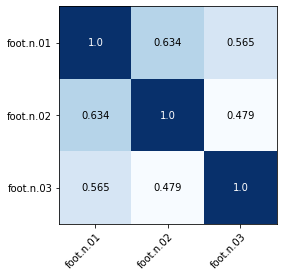

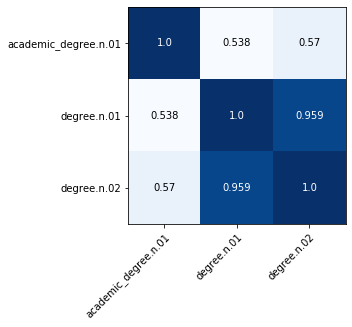

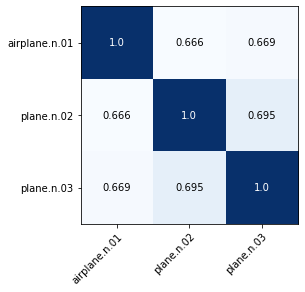

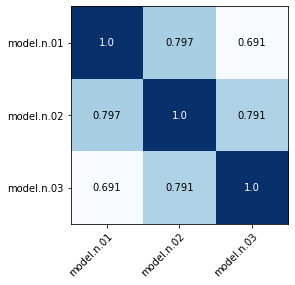

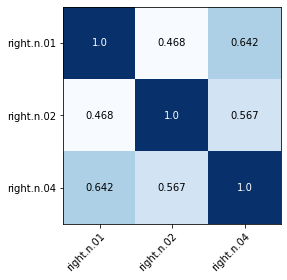

In [167]:
for w in shared_words:
    result_mtx, sense_names = cosine_sim_mtx(w, 'n',
                                             sel_senses = [fb_to_local(s) for s in get_senses(db, w + "_n")])
    fig, ax = plt.subplots()
    im = ax.imshow(result_mtx)
    annotate_mtx(result_mtx, im, ax, sense_names)